In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve,roc_auc_score

# Data Retrieval and Understanding

In [2]:
df=pd.read_csv('/kaggle/input/fraudulent-transactions-data/Fraud.csv')

In [3]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [5]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [6]:
df.duplicated().sum()

0

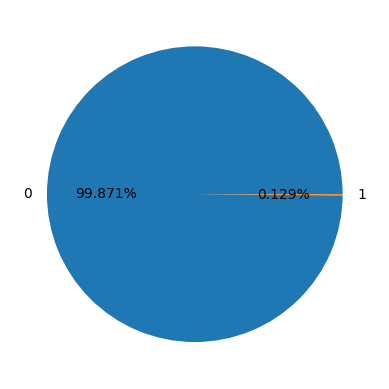

In [7]:
plt.pie(df["isFraud"].value_counts(),labels=df["isFraud"].unique(),autopct='%1.3f%%')
plt.show()

In [8]:
df["isFraud"].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

# Feature engineering

how much amount has been debited from payer's account in effect to the transaction?

In [9]:
df["payerdebited"]=df["oldbalanceOrg"]-df["newbalanceOrig"]
df["payerdebited"].describe()

count    6.362620e+06
mean    -2.123056e+04
std      1.466433e+05
min     -1.915268e+06
25%      0.000000e+00
50%      0.000000e+00
75%      1.015044e+04
max      1.000000e+07
Name: payerdebited, dtype: float64

**How much amount has been credited to reciever's account in effect to the transaction?**

In [10]:
df["recievercredited"]=df["newbalanceDest"]-df["oldbalanceDest"] 
df["recievercredited"].describe()

count    6.362620e+06
mean     1.242947e+05
std      8.129391e+05
min     -1.306083e+07
25%      0.000000e+00
50%      0.000000e+00
75%      1.491054e+05
max      1.056878e+08
Name: recievercredited, dtype: float64

Is the reciever a merchant (M) or customer (C)?

In [11]:
df["reciever_type"]=[i[0:1] for i in df["nameDest"]] # is the reciever a merchant (M) or customer (C)?
df["reciever_type"].value_counts()

reciever_type
C    4211125
M    2151495
Name: count, dtype: int64

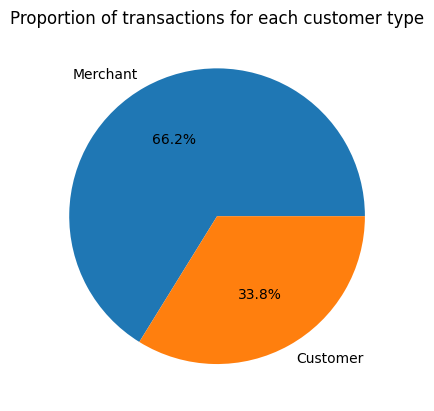

In [12]:
plt.pie(df["reciever_type"].value_counts(), labels=["Merchant","Customer"],autopct='%1.1f%%')
plt.title("Proportion of transactions for each customer type")
plt.show()

Is the payer a merchant (M) or customer (C)?

In [13]:
df["payer_type"]=[i[0:1] for i in df["nameOrig"]] # is the payer a merchant (M) or customer (C)?
df["payer_type"].value_counts()

payer_type
C    6362620
Name: count, dtype: int64

To make the features related to the real world, lets assume that the dataset belongs to April, 2024 as the financial year begins with April and it is exactly 30 days long. 

In [14]:
df['datetime'] = pd.to_datetime('2024-04-01') + pd.to_timedelta(df['step'], unit='h')

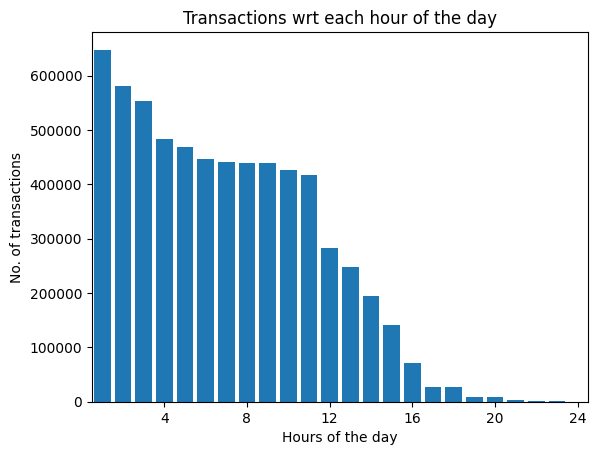

In [15]:
df['hour'] = df['datetime'].dt.hour
plt.bar(df['hour'].unique(),df['hour'].value_counts())
plt.xlim(0.5,24.5)
plt.xticks(range(4,25,4))
plt.xlabel("Hours of the day")
plt.ylabel("No. of transactions")
plt.title("Transactions wrt each hour of the day")
plt.show()

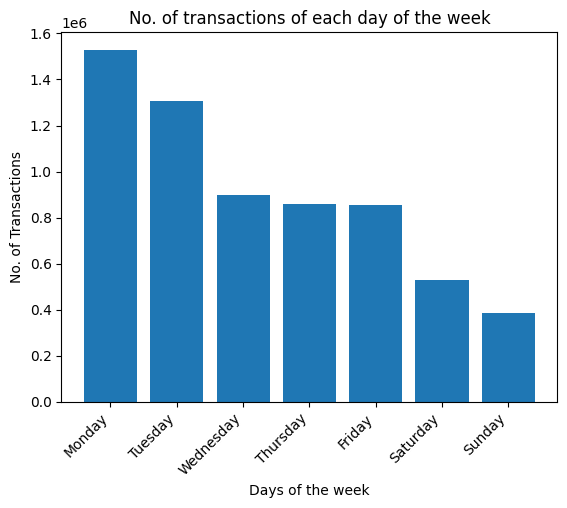

In [16]:
df['day_of_week'] = df['datetime'].dt.dayofweek
plt.bar(["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"],df['day_of_week'].value_counts())
plt.xticks(rotation=45, ha='right')
plt.xlabel("Days of the week")
plt.ylabel("No. of Transactions")
plt.title("No. of transactions of each day of the week")
plt.show()

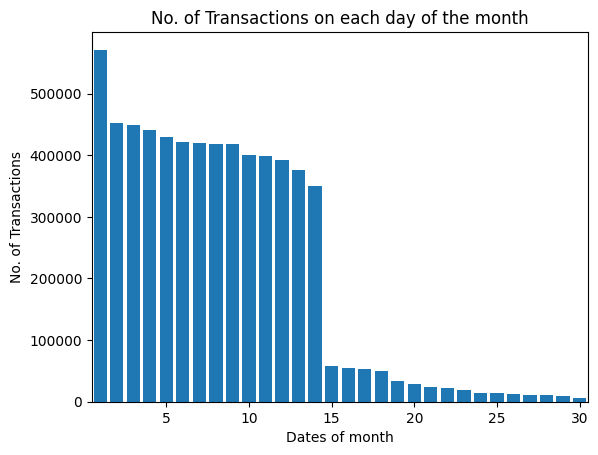

In [17]:
df['date'] = df['datetime'].dt.day
plt.bar(df['date'].unique(),df['date'].value_counts())
plt.xlim(0.5,30.5)
plt.xlabel("Dates of month")
plt.ylabel("No. of Transactions")
plt.title("No. of Transactions on each day of the month")
plt.show()

In [18]:
df["type"].value_counts()

type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64

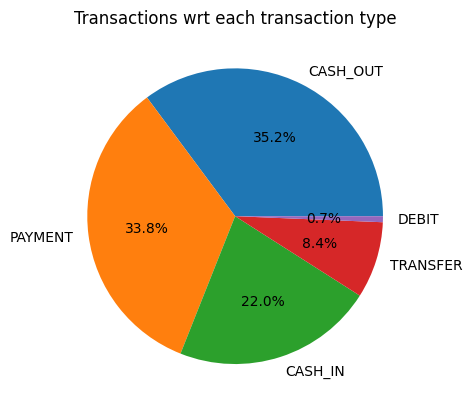

In [19]:
plt.pie(df["type"].value_counts(), labels=df["type"].value_counts().index,autopct='%1.1f%%')
plt.title("Transactions wrt each transaction type")
plt.show()

In [20]:
todrop=["nameDest",
        "nameOrig",
        "oldbalanceOrg",
        "newbalanceOrig",
        "newbalanceDest",
        "oldbalanceDest",
        "payer_type", #this is a zero variance feature
        "step", #extracted hour,date and day_of_week
        "datetime",
        "isFlaggedFraud"]
df.drop(columns=todrop, inplace=True)

Label Encoding of Categorical columns

In [21]:
cat_cols=[col for col in df.columns if df[col].dtype=="object"]
encoder=LabelEncoder()
encoded_df=df.copy()
mappings={}
for col in cat_cols:
    encoded_df[col]=encoder.fit_transform(df[col])
    mappings[col]=pd.Series(encoder.transform(encoder.classes_),index=(encoder.classes_))

**correlation matrix will tell us which features show multicollinearity**

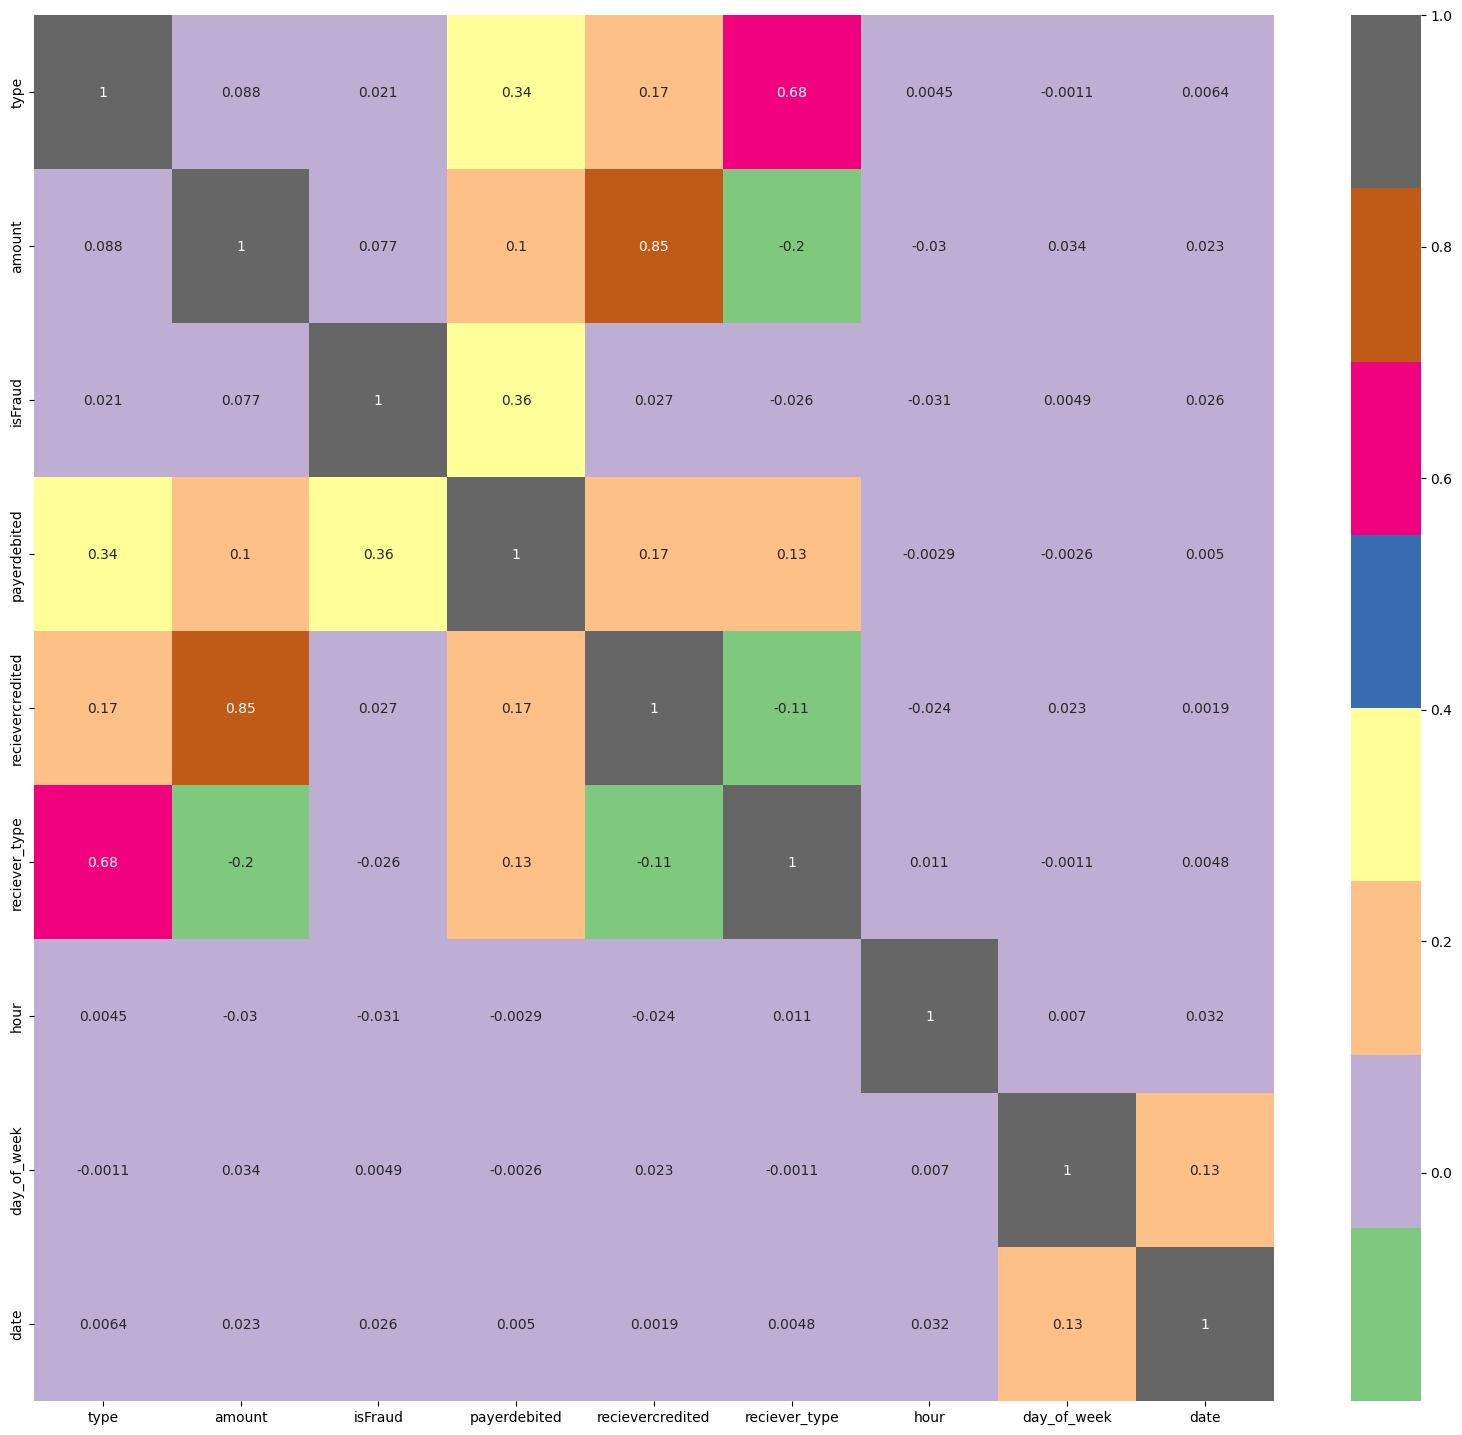

In [22]:
plt.figure(figsize=(20,18))
corr = encoded_df.corr()
sns.heatmap(corr, annot = True, cmap="Accent")
plt.show()

Since amount and recievercredited are highly correlated to each other, we have to remove one of them to avoid overfitting

In [23]:
encoded_df.drop(columns=["recievercredited"],inplace=True)

code to display which categories in each categorical variable have been mapped to which numerical value by the label encodder

In [24]:
for col,mapping in mappings.items():
    print(f"mappings for df[{col}]:\n{mapping} \n")

mappings for df[type]:
CASH_IN     0
CASH_OUT    1
DEBIT       2
PAYMENT     3
TRANSFER    4
dtype: int64 

mappings for df[reciever_type]:
C    0
M    1
dtype: int64 



function to count the number of outliers

In [25]:
def outlier_count(data):
    Q1=data.quantile(.25)
    Q3=data.quantile(.75)
    IQR=Q3-Q1
    upwhisk=Q3+(IQR*1.5)
    lowhisk=Q1-(IQR*1.5)
    outlier_count=0
    for i in range(len(data)):
        if data[i]>upwhisk or data[i]<lowhisk:
            outlier_count=+1
    return outlier_count

In [26]:
outliers=0
columns=encoded_df.drop(columns=["isFraud"])
for col in columns:
    outliers+=outlier_count(encoded_df[col])
print(f'No of Outliers:{outliers}')

No of Outliers:4


# Training and building the model

In [27]:
x=encoded_df.drop(columns="isFraud") #independent variables

Since an attempt to transfer more than 200,000 in a single transaction is an illegal attempt, we modify the target variable accordingly  

In [28]:
y = pd.Series([
    1 if encoded_df.loc[i, "amount"] > 200000 else encoded_df.loc[i, "isFraud"] for i in range(len(encoded_df))
    ]) # dependent variable

In [29]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [30]:
forest=RandomForestClassifier(n_estimators=15,class_weight='balanced',criterion='entropy',random_state=42)
forest.fit(x_train,y_train)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       n_estimators=15, random_state=42)

In [31]:
def illegal_transac(amount, model_prediction):
    if amount > 200000:
        return 1  # Fraud
    else:
        return model_prediction
y_hat=[illegal_transac(amount, pred) for amount, pred in zip(x_test['amount'], forest.predict(x_test))]

# Evaluating the performance of Random Forests classifier

In [32]:
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    936581
           1       1.00      1.00      1.00    335943

    accuracy                           1.00   1272524
   macro avg       1.00      1.00      1.00   1272524
weighted avg       1.00      1.00      1.00   1272524



**Confusion matrix**

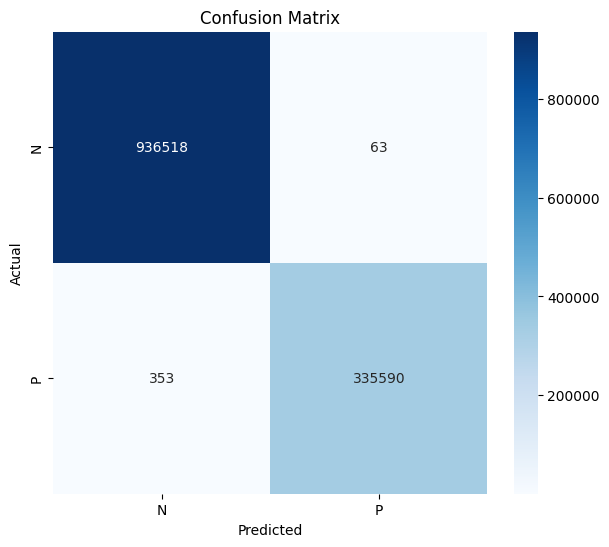

In [33]:
con_mat=confusion_matrix(y_test, y_hat)
class_names = 'NP'
plt.figure(figsize=(7,6))
sns.heatmap(con_mat, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [34]:
y_probs = forest.predict_proba(x_test)[:, 1]  # Probability estimates for the positive class

**ROC AUC curve**

In [35]:
def roc_auc_curve(Y_test,Y_prob):
    fpr, tpr, thresholds = roc_curve(Y_test, Y_prob)
    roc_auc = roc_auc_score(Y_test, Y_prob)
    plt.figure()
    plt.plot(fpr, tpr, label='Isolation Forest (AUC = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

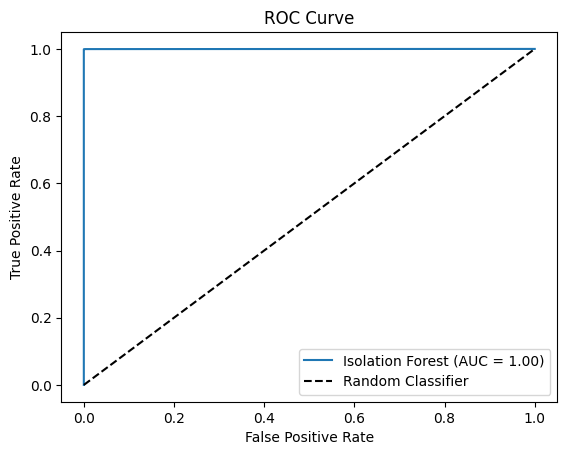

In [36]:
roc_auc_curve(y_test,y_probs)

# YAY!! our model is performing perfectly on our validation data🎊🥳